Tasks:
1. Complete the complexity analysis
2. Present the optimization_ops...
3. Add an analysis comparing to the VQE results
4. Add advantanges and disadvantages of the ADAPT-VQE
5. Should the qmod be where it is, should I add another qmod?

# ADAPT VQE

> The **Adaptive Derivative-Assembled Pseudo-Trotter Variational Quantum Eigensolver (ADAPT-VQE)** [[1](#ADAPT-VQE)] is a variational hybrid algorithm, which constitutes an extension of the Variational Quantum Eigensolver (VQE) framework [[2](#VQE)], that constructs problem-specific ansätze in a systematic and adaptive manner. Instead of relying on a fixed, heuristic circuit structure, ADAPT-VQE iteratively grows the state ansatz by selecting operators from a predefined pool based on their energy gradients with respect to the current variational state. At each iteration, the operator that yields the largest energy reduction is appended to the circuit and its parameters are reoptimized. This adaptive procedure significantly reducing the number of variational parameter and circuit depth, making ADAPT-VQE particularly well suited for near-term quantum hardware.
>
> The algorithm treats the following problem:
>
> - **Input:** System Hamiltonian $H$, reference state $| \Psi_{\text{ref}}\rangle$ and an operator pool of anti-Hermitian operators ${\cal O} =\{O_1,\dots,O_M\}$.
> - **Output:** Approximation of the ground state and energy.
>
> **Complexity:** 
>
> ---
>
> **Keywords:**  Variational quantum algorithm, Chemistry, Optimization

## Overview

The following notebook begins with a theoretical explanation of the algorithm. We then consider an explicit example, consisting of a system of four qubits. The ADAPT-VQE algorithm is employed to evaluate the ground state energy and state. Following, the results are compared to the results obtained by the standard VQE algorithm. The notebook concludes by an analysis of the results and a summary of the advantages and disadvantages of the ADAPT-VQE algorithm.


## Algorithm steps
The algorithm builds and constructs the ansatz iteratively, one operator at a time, including only the most significant operators. This approach builds a minimal, problem-specific ansatz, avoiding unnecessary parameters and allowing systematic improvement of the accuracy. Similarly to VQE, the algorithms essentially reduce the circuit depth at the expense of measurements. 

Initially, we define an operator pool ${\cal O}=\{O_1,O_2,\cdots,O_M\}$, containing a collection of anti-Hermitian operators that are employed in the ansatz construction.

We then follow the following procedure:
1. Initialize the qubits to the reference state, $| \Psi_{\text{ref}}\rangle$, and define the initial iterative state as $| \psi^{(0)}\rangle = | \Psi_{\text{ref}} \rangle$.
2. Prepare a trial quantum state with the current ansatz, denoted by $|\psi^{(n)}\rangle$, where $n=0,1,\dots$ corresponds to the iteration step number (initially set to zero).
3. Measure the commutator of the Hamiltonian with the operators of $\cal{O}$. The expectation value corresponds to the partial derivative of the energy (in the $n$ iteration step) with respect to the coefficient of $O_j$: $$\frac{\partial E^{(n+1)}}{\partial \theta_j}\bigg |_{\theta_j=0} = \langle\psi^{(n)}|\partial_{\theta_i}e^{-\theta_i O_j} H e^{O_j \theta_j}|\psi^{(n)}\rangle {\bigg |}_{\theta_j = 0}+ \langle\psi^{(n)}|e^{-\theta_j O_j} H \partial_{\theta_j}e^{O_j \theta_j}|\psi^{(n)}\rangle {\bigg |}_{\theta_j = 0}$$ $$= {{\langle \psi^{(n)}|  [H, O_j] |\psi^{(n)}\rangle}}~.$$ Hence, the measured commutation relations, provides the gradiant $\nabla_\vec{\theta} E$, where $\vec{\theta} = \{\theta_1,\dots,\theta_M\}^T~~.$ 
4. If the magnitude of the gradient vector is below a certain threshold, stop. Otherwise, identify the operator with the largest gradient, and add it to the left end of the ansatz, with a new variational parameter. If $A_n\in \{O_i\}$ is an operator with the largest gradient on the step $n$, the update rule is given by $$|\psi^{(n+1)} \rangle = e^{\theta_n A_n} |\psi^{(n)}\rangle~~.$$  Note, that the added operator still remains in the operator pool, therefore may be added again later on.
5. Conduct a VQE experiment to re-optimize all the ansatz parameters, $\{\theta_1,\dots,\theta_n\}$.
6. Go back to step 3 and take $n\rightarrow n+1$.


The final optimized ansatz is of the form $$| \psi^{\text{ADAPT}}(\vec{\theta}) \rangle = \Pi_{n=1}^{p} e^{\theta_n A_n}|\psi_{\text{ref}}\rangle~~,$$ where $p$ is the total number of iterations.

Note that when multiple quantum computers are available, the preparation of the trial state and measurement of the commutation relations with the Hamiltonian can be performed in parallel, substantially reducing the runtime.

## Implementation of ADPT-VQE with Classiq

We consider a simple example, consisting of a four-qubit system. The Hamiltonian and operator pool are defined in terms of the [SparsePauliOp](https://docs.classiq.io/latest/qmod-reference/api-reference/classical-types/?h=sparsepauliop#classiq.qmod.builtins.structs.SparsePauliOp) data structure, allowing for rapid and efficient algebraic computations.
For implementation convenience, we consider an operator pool of Hermitian operators (instead of anti-Hermitian as in the theoretical derivation). In this case, the ansatz stat is of the form 
$$| \psi^{\text{ADAPT}}(\vec{\theta}) \rangle = \Pi_{n=1}^{p} e^{-i\theta_n A_n}|\psi_{\text{ref}}\rangle~~,$$
leading to the relation
$$\frac{\partial E^{(n+1)}}{\partial \theta_j}\bigg |_{\theta_j=0} = -i{{\langle \psi^{(n)}|  [H, O_j] |\psi^{(n)}\rangle}}~~.$$

We begin by uploading software packages and utility functions

In [1]:
from functools import reduce
from operator import add, mul
from typing import Final, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

### Utility functions
We employ utility functions form the [ADAPT-QAOA notebook](https://github.com/Classiq/classiq-library/blob/main/applications/optimization/adapt_qaoa/adapt_qaoa.ipynb), used to efficiently compute the commutation of Pauli strings with the `SparsePauilOp` data structure. These are used in the computation of $\langle \psi^{(n)} | [H, O_j] | \psi^{(n)}\rangle$.

The functions perform the following tasks:
- `sorted_pauli_term` sorts Pauli terms according to the qubit's index.
- `commutator` receives two `SparsePauilOp`s and returns their commutator as a `SparsePauilOp`.
- `normalize_pauli_term` removes redundant Pauli identity operators, allowing for comparison and addition of two `SparsePauilOp`s.
- `collect_pauli_terms` adds up the coefficients of identical Pauli strings.

In [2]:
# multiplication table of two Pauli matrices
# weight (imaginary), pauli_c = pauli_a * pauli_b
pauli_mult_table: list[list[Tuple[int, int]]] = [
    [(+0, Pauli.I), (+0, Pauli.X), (+0, Pauli.Y), (+0, Pauli.Z)],
    [(+0, Pauli.X), (+0, Pauli.I), (+1, Pauli.Z), (-1, Pauli.Y)],
    [(+0, Pauli.Y), (-1, Pauli.Z), (+0, Pauli.I), (+1, Pauli.X)],
    [(+0, Pauli.Z), (+1, Pauli.Y), (-1, Pauli.X), (+0, Pauli.I)],
]


def sorted_pauli_term(term: SparsePauliTerm) -> SparsePauliTerm:
    """
    Sort Pauli terms according to the qubit's index, e.g.,
    Pauli.X(2)*Pauli.Z(7)*Pauli.X(4) ==> Pauli.X(2)*Pauli.X(4)*Pauli.Z(7)
    """
    sorted_paulis = sorted(term.paulis, key=lambda p: p.index)
    return SparsePauliTerm(sorted_paulis, term.coefficient)


def commutator(ha: SparsePauliOp, hb: SparsePauliOp) -> SparsePauliOp:
    """
    Compute the commutator [ha, hb] = ha*hb - hb*ha, where ha and hb are SparsePauliOp objects.
    Returns a SparsePauliOp representing the commutator.
    """
    n = max(ha.num_qubits, hb.num_qubits)
    commutation = SparsePauliOp([], n)

    for sp_term_a in ha.terms:
        for sp_term_b in hb.terms:
            parity = 1
            coefficient = 1.0
            msp = {p.index: p.pauli for p in sp_term_a.paulis}
            for p in sp_term_b.paulis:
                pauli_a = msp.get(p.index, Pauli.I)
                pauli_b = p.pauli
                weight, pauli = pauli_mult_table[pauli_a][pauli_b]
                if weight != 0:
                    parity = -parity
                    coefficient *= weight * 1j
                msp[p.index] = pauli
            # reconstruct pauli_string
            if parity != 1:
                # consider filtering identity terms, making sure the term is not empty
                pauli_term = (reduce(mul, (p(idx) for idx, p in msp.items()))).terms[0]
                pauli_term.coefficient = (
                    sp_term_a.coefficient * sp_term_b.coefficient * coefficient * 2
                )
                commutation.terms.append(pauli_term)
    return commutation


def normalize_pauli_term(spt: SparsePauliTerm, num_qubits=-1) -> SparsePauliTerm:
    """
    Remove redundant Pauli.I operators from a Pauli string
    making "normalized" strings comparable
    if num_qubits is set, an optional Pauli.I is added to ensure the length
    """
    if not spt.paulis:
        return spt

    npt = sorted_pauli_term(spt)

    paulis = []
    max_index = max_identity_index = -1
    if num_qubits > 0:
        max_identity_index = num_qubits - 1
    for ip in npt.paulis:
        if ip.pauli != Pauli.I:
            paulis.append(ip)
            max_index = max(max_index, int(ip.index))
        else:
            max_identity_index = max(max_identity_index, int(ip.index))

    if max_identity_index > max_index:
        paulis.append(IndexedPauli(Pauli.I, max_identity_index))

    npt.paulis = paulis
    return npt


def collect_pauli_terms(spo: SparsePauliOp) -> SparsePauliOp:
    """
    Collect the coefficient of identical Pauli strings
    for example: 1.5*"IXZI"-0.3*"IXXZ"+0.4*"IXZI", would result, in:
    1.9*"IXZI"-0.3*"IXXZ".
    The function correctly ignores "I" when comparing strings, and sets the correct `num_qubits`
    terms with abs(coefficient)<TOLERANCE are dropped
    """
    TOLERANCE: Final[float] = 1e-10
    pauliterms = {}
    for term in spo.terms:
        npt = normalize_pauli_term(term, spo.num_qubits)
        key = tuple((ip.pauli, int(ip.index)) for ip in npt.paulis)
        pauliterms[key] = pauliterms.get(key, 0) + term.coefficient

    def single_qubit_op(pair: tuple[int, int]) -> SparsePauliOp:
        p_int, idx = pair
        term = SparsePauliTerm([IndexedPauli(Pauli(p_int), idx)], 1.0)
        return SparsePauliOp([term], num_qubits=idx + 1)

    paulistrings = []
    for key, coeff in pauliterms.items():
        if np.abs(coeff) < TOLERANCE:
            continue
        key_op = reduce(mul, (single_qubit_op(pair) for pair in key))
        paulistrings.append(coeff * key_op)

    if not paulistrings:
        return SparsePauliOp([], spo.num_qubits)

    # Sum all strings
    return reduce(add, paulistrings)

Next, we define the `grad_energy` function, which receives an operator, `op`, and Hamiltonian, `hamiltonian`, as `SpasePauilOp`s, and evaluates the absolute value of the expectation value of the commutation relation $\nabla_{\vec{\theta}} E_j=i\langle\psi^{(n)}|[H,O_j] |\psi^{(n)}\rangle~~,$ with respect to an execution session `es` and optimization parameters `params`.

In [25]:
def grad_energy(
    op: SparsePauliOp,
    hamiltonian: SparsePauliOp,
    es: ExecutionSession,
    params: list[float],
) -> float:
    h_op_comm = -1j * commutator(hamiltonian, op)
    return es.estimate(h_op_comm, {"params": params}).value

## Defining the Example System and Operator Pool

In [60]:
HAMILTONIAN = (
    -0.1 * Pauli.Z(0) * Pauli.Z(1)
    + 0.2 * Pauli.X(0)
    - 0.3 * Pauli.Z(1) * Pauli.Z(2)
    + 0.4 * Pauli.Z(1)
    - 0.1 * Pauli.Y(2) * Pauli.Z(3)
    + 0.2 * Pauli.Y(2)
    - 0.5 * Pauli.X(2) * Pauli.Z(3)
    + 0.2 * Pauli.Z(3)
    - 0.1 * Pauli.Y(1)
    + 0.3 * Pauli.I(0)
)

NUM_QUBITS = 4

op_pool = [Pauli.X(i) for i in range(4)]
Hamiltonian_matrix = hamiltonian_to_matrix(HAMILTONIAN)
eigvals, eigvecs = np.linalg.eig(Hamiltonian_matrix)
minimum_energy = np.real(np.min(eigvals))

In [62]:
print(f" Minimum energy: {minimum_energy}")

 Minimum energy: -1.189380715792109


### Main program



Before defining the ADAPT-VQE main function, we first define the `adapt_vqe_ansatz` function, which prepares the product state of phases, $|\psi^{\text{ADAPT}}(\vec{\theta})) \rangle = \Pi_{n=1}^{p} e^{-i\theta_n A_n}|\psi_{\text{ref}}\rangle$, defined by the optimization parameters, `thetas`, and the associated operators of the operator pool, $\cal O$.
The function builds the state, phase by phase, utilizing a helper function `adapt_layer`. 
The reference state is taken to be $$|\psi_{\text{ref}}\rangle=|0^N \rangle~~,$$ where $N=4$ is the number of qubits.

In [5]:
@qfunc
def adapt_layer(idx: int, theta: CReal, qba: QArray):
    suzuki_trotter(op_pool[idx], theta, 1, 1, qba)


@qfunc
def adapt_vqe_ansatz(
    thetas: CArray[CReal],
    ansatz_ops: List[int],
    qba: QArray,
):
    n = thetas.len
    for i in range(n):
        adapt_layer(ansatz_ops_indicies[i], thetas[i], qba)

Following the algorithm steps, the main ADAPT-VQE performs an iterative calculation, each time adding another phase to the ansatz, thereby increasing the ansatz length, `p`, (starting from $p=1$) until the gradient converges and satisfies $|\nabla E|/p <$`tol`. If the procedure does not converge, we limit the number of iterations by `MAX_ITERATIONS`.

Each iteration begins with a preparation of the ansatz state $\Pi_{n=1}^{p} e^{-i\theta_n A_n}|\psi_{\text{ref}}\rangle$ for the current $p$. The state preparation is performed by the first `main` quantum function, the quantum circuit is synthesized, and the optimization parameters are optimized by the `es` execution call and saved as a Python list in `params`. The `params` parameters, along with the operators represented by the associated operator indices stored in the `ansatz_ops`, completely define the ansatz state. 

Finally, the elements of the gradient, $\nabla_{\vec{\theta}}E$, are evaluated by the execution call using the `grad_energy` function. A convergence check is made; if the ansatz state converged or the number of iterations exceeds the limit, the iterative procedure is terminated; otherwise, the iteration cycle continues.  

In [51]:
# maximum number of iterations
MAX_ITERATIONS = 20

# stores the optimization parameters of the recent iteration
last_params = []

ansatz_ops_indicies: list[int] = []
# start with default parameter
ansatz_ops_indicies.append(0)

# stores the gradient norms
gradient_norms = []

# stores the minimal gradient element in each step
picked_derivatives = []

# ansatz state energy
energies = []

# gradient norm tolerance for stopping criterion
tol: Final[float] = 0.027

while True:  # loop until gradient norm exceeds tolerance (break-ing out of the loop)
    # number of layers (initially=1)
    p = len(ansatz_ops_indicies)
    # trace and history for analysis and plotting
    cost_trace = []
    params_history = []

    @qfunc
    def main(params: CArray[CReal, p], v: Output[QArray[QBit, NUM_QUBITS]]):
        allocate(v)
        n = params.len
        # print(f"Building ansatz with {n} layers.")
        adapt_vqe_ansatz(params, ansatz_ops_indicies, v)

    qprog = synthesize(main)

    # write an equivalent qmod file
    write_qmod(main, name="adapt_vqe", decimal_precision=15, symbolic_only=False)

    # initial optimization parameters for the VQE re-optimization
    initial_params = np.linspace(0, 1, p).tolist()
    with ExecutionSession(qprog) as es:
        optimization_results = es.minimize(
            cost_function=HAMILTONIAN,  # Hamiltonian problem
            initial_params={"params": initial_params},
            max_iteration=100,
        )

    params = optimization_results[-1][1]["params"]
    last_params = params[:]  # copy for final execution

    energies.append(optimization_results[-1][0])

    ## Compute gradients of operator pool elements
    @qfunc
    def main(
        params: CArray[CReal, p],
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        adapt_vqe_ansatz(params, ansatz_ops_indicies, v)

    # print("Computing operator gradients...")

    qprog_grads = synthesize(main)

    with ExecutionSession(qprog_grads) as es:
        gradients = np.array(
            [grad_energy(mp, HAMILTONIAN, es, params) for mp in op_pool]
        )

    # evaluate the scaled gradient norm
    scaled_gradient_norm = np.linalg.norm(gradients) / len(gradients)
    gradient_norms.append(scaled_gradient_norm)
    print(f"scaled gradient norm: {scaled_gradient_norm}")

    # convergence check
    if scaled_gradient_norm < tol:
        print(f"Gradient converged")
        break

    positive_gradient = np.all(gradients >= 0)
    # if positive_gradient:
    #    print(f"Optimization reached a minima")
    #    break
    print(f"gradients: {gradients}")
    g_idx = np.argmin(gradients)
    picked_derivatives.append(gradients[g_idx])
    print(f"Selected operator index: {g_idx}")

    ansatz_ops_indicies.append(g_idx)
    print(f"energies: {energies}")

scaled gradient norm: 0.07106133025723953
gradients: [-0.00800781+0.j -0.19980469+0.j  0.20175781+0.j -0.01015625+0.j]
Selected operator index: 1
energies: [0.50546875]
scaled gradient norm: 0.04582823233684529
gradients: [ 0.01933594+0.j -0.01074219+0.j  0.18125   +0.j  0.01621094+0.j]
Selected operator index: 1
energies: [0.50546875, 0.27314453125]
scaled gradient norm: 0.048657563433746685
gradients: [ 0.04101562+0.j -0.04101563+0.j  0.18535156+0.j -0.01269531+0.j]
Selected operator index: 1
energies: [0.50546875, 0.27314453125, 0.26953125]
scaled gradient norm: 0.05784474066695389
gradients: [ 0.12128906+0.j  0.00371094+0.j  0.19472656+0.j -0.02988281+0.j]
Selected operator index: 3
energies: [0.50546875, 0.27314453125, 0.26953125, 0.31015624999999997]
scaled gradient norm: 0.15240269229843684
gradients: [-0.02207031+0.j  0.02382812+0.j  0.60722656+0.j  0.04296875+0.j]
Selected operator index: 0
energies: [0.50546875, 0.27314453125, 0.26953125, 0.31015624999999997, -0.1217773437500

ReadError: 

## Results and Discussion

### Energy graph

In [ ]:
plt.plot(energies)
plt.plot(np.array(len(energies) * [ground_state_energy]))
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Ansatz State Energy")
plt.show()

### Convergence graph

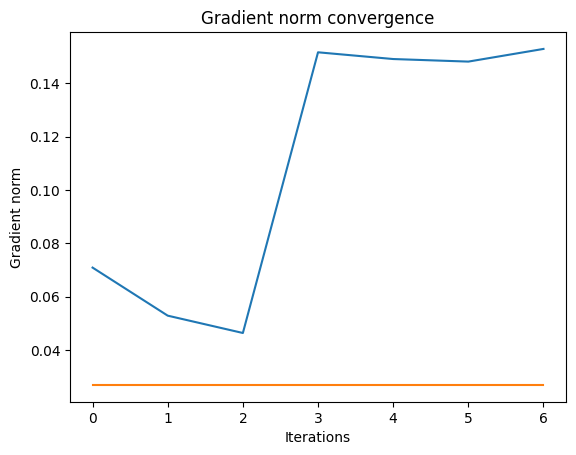

In [42]:
plt.plot(gradient_norms)
plt.plot(np.array(len(gradient_norms) * [tol]))
plt.xlabel("Iterations")
plt.ylabel("Gradient norm")
plt.title("Gradient norm convergence")
plt.show()

### Optimized State Ansatz

In [44]:
# optimized ground state energy
print(f"minimal energy: {optimization_results[-1][0]}")

# optimized thetas (rounded)
optimized_thetas = [optimization_results[-1][1]["params"]][0]
rounded_thetas = [round(optimized_thetas[i], 3) for i in range(len(optimized_thetas))]
print(f"optimized thetas: {rounded_thetas}")

minimal energy: 0.5208007812500001
optimized thetas: [-0.0]


In [10]:
# associated operators
optimization_ops = [op_pool[idx] for idx in ansatz_ops_indicies]
print(f"optimization operators: {optimization_ops}")

optimization operators: [SparsePauliOp(terms=[SparsePauliTerm(paulis=[IndexedPauli(pauli=<Pauli.X: 1>, index=0)], coefficient=1.0)], num_qubits=1), SparsePauliOp(terms=[SparsePauliTerm(paulis=[IndexedPauli(pauli=<Pauli.X: 1>, index=1)], coefficient=1.0)], num_qubits=2), SparsePauliOp(terms=[SparsePauliTerm(paulis=[IndexedPauli(pauli=<Pauli.X: 1>, index=2)], coefficient=1.0)], num_qubits=3)]


### Circuit Information

The circuit width and depth are:

In [41]:
# circuit width
print(f"circuit width: {qprog.data.width}")
# circuit depth
print(f"circuit depth: {qprog.transpiled_circuit.depth}")

circuit width: 4
circuit depth: 6


## Comparison to the VQE algorithm

We now validate the results of the ADAPT-VQE by comparing them to the outcome of the standard VQE algorithm, with the same number of optimization parameters, `p`. We fix the ansatz state by considering a product form of phases, $$|\psi_{\text{VQE}}\rangle = \Pi_{n=1}^{p} e^{-i \theta_n O_n}|0^N\rangle~~,$$ where $N=4$ in the presented test case. The operators $\{O_n\}$ are determined by their operator pool indices in `vqe_ansatz_ops_indicies` and the associated parameters $\{\theta_n\}$ are optimized by applying the VQE algorithm.


In [23]:
modular_range = [i + 2 % len(op_pool) for i in range(p - 1)]
modular_range = [0] + modular_range
vqe_ansatz_ops_indicies = modular_range


@qfunc
def main(params: CArray[CReal, p], v: Output[QArray[QBit, NUM_QUBITS]]):
    allocate(v)
    n = params.len
    adapt_vqe_ansatz(params, vqe_ansatz_ops_indicies, v)


qprog = synthesize(main)


with ExecutionSession(qprog) as es:
    vqe_optimization_results = es.minimize(
        cost_function=HAMILTONIAN,  # Hamiltonian problem
        initial_params={"params": [0] * p},
        max_iteration=100,
    )

print(f"VQE minimal energy: {vqe_optimization_results[-1][0]}")

# optimized thetas (rounded)
vqe_optimized_thetas = [vqe_optimization_results[-1][1]["params"]][0]
vqe_rounded_thetas = [
    round(vqe_optimized_thetas[i], 3) for i in range(len(vqe_optimized_thetas))
]
print(f"VQE optimized thetas: {vqe_rounded_thetas}")

VQE minimal energy: -0.3187500000000001
VQE optimized thetas: [-1.581, -1.512, 1.346]


## Analysis and Summary

COMPLETE
Analysis:

The ADAPT-VQE ...

## References

<a id='ADAPT-VQE'>[1]</a>: [Grimsley, H. R., Economou, S. E., Barnes, E., & Mayhall, N. J. (2019). An adaptive variational algorithm for exact molecular simulations on a quantum computer. Nature communications, 10(1), 3007.](https://arxiv.org/abs/1812.11173)

<a id='VQE'>[2]</a>: [Tilly, J., Chen, H., Cao, S., Picozzi, D., Setia, K., Li, Y., ... & Tennyson, J. (2022). The variational quantum eigensolver: a review of methods and best practices. Physics Reports, 986, 1-128.](https://arxiv.org/abs/2111.05176)